<a href="https://colab.research.google.com/github/sosmany1/Semiotics-Generative-Model./blob/master/Steering_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Based on GAN Steerability paper by Lucy Chai and Ali Jahanian: https://arxiv.org/abs/1907.07171
# Read this paper for better BigGAN: https://arxiv.org/abs/1912.00953
# clone BigGAN PyTorch model
! git clone https://github.com/ajbrock/BigGAN-PyTorch.git 

Cloning into 'BigGAN-PyTorch'...
remote: Enumerating objects: 497, done.
remote: Total 497 (delta 0), reused 0 (delta 0), pack-reused 497
Receiving objects: 100% (497/497), 5.59 MiB | 7.21 MiB/s, done.
Resolving deltas: 100% (332/332), done.


In [0]:
ls /content 


BigGAN-PyTorch/  sample_data/


In [0]:
cd /content/BigGAN-PyTorch 

/content/BigGAN-PyTorch


In [0]:
ls

animal_hash.py                  inception_utils.py  sample.py
BigGANdeep.py                   layers.py           scripts/
BigGAN.py                       LICENSE             sync_batchnorm/
calculate_inception_moments.py  logs/               TFHub/
datasets.py                     losses.py           train_fns.py
imgs/                           make_hdf5.py        train.py
inception_tf13.py               README.md           utils.py


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')  


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ls /content/gdrive/My\ Drive/gan_steerability_tutorial/weights_model/100k/

G_ema.pth


In [0]:
#importing BigGAN weights 
weights_path = "/content/gdrive/My Drive/gan_steerability_tutorial/weights_model/100k/G_ema.pth"


In [0]:
#importing pre-trained classifier weights. Uncomment this to incporote:
#weights_path = " content/gdrive/My\ Drive/classifier_1e-3.pth/ "


In [0]:
import numpy as np
import functools
from PIL import Image
import IPython.display
import time
import cv2

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import utils

In [0]:
# checking gpu is availability
torch.cuda.device_count()

1

In [0]:
print(utils.__file__)

/content/BigGAN-PyTorch/utils.py


In [0]:
parser = utils.prepare_parser()
parser = utils.add_sample_parser(parser)
config = vars(parser.parse_args('')) # use default arguments

In [0]:
# See: https://github.com/ajbrock/BigGAN-PyTorch/blob/master/scripts/sample_BigGAN_bs256x8.sh.
config["resolution"] = utils.imsize_dict["I128_hdf5"]
config["n_classes"] = utils.nclass_dict["I128_hdf5"]
config["G_activation"] = utils.activation_dict["inplace_relu"]
config["D_activation"] = utils.activation_dict["inplace_relu"]
config["G_attn"] = "64"
config["D_attn"] = "64"
config["G_ch"] = 96
config["D_ch"] = 96
config["hier"] = True
config["dim_z"] = 120
config["shared_dim"] = 128
config["G_shared"] = True
config = utils.update_config_roots(config)
config["skip_init"] = True
config["no_optim"] = True
config["device"] = "cuda"
config['batch_size'] = 4

In [0]:
# Seed RNG.
utils.seed_rng(config["seed"])

# Set up cudnn.benchmark for free speed.
torch.backends.cudnn.benchmark = True

In [0]:
# Import BigGAN model.
model = __import__(config["model"])
experiment_name = utils.name_from_config(config)
G = model.Generator(**config).to(config["device"])
utils.count_parameters(G)

Adding attention layer in G at resolution 64
Number of parameters: 70433988


In [0]:
# Load weights.
G.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [0]:
# Update batch size setting used for G
# And prepare z and y distributions
G_batch_size = max(config["G_batch_size"], config["batch_size"])
(z_, y_) = utils.prepare_z_y(
    G_batch_size,
    G.dim_z,
    config["n_classes"],
    device=config["device"],
    fp16=config["G_fp16"],
    z_var=config["z_var"],
)

G.eval();

In [0]:
# Generate a random sample from the model to test everything is working
# Don't need gradients for this step since we are not training anything
# Wrap the forward pass with torch.no_grad
with torch.no_grad():
    z_.sample_()
    y_.sample_()
    image_tensors = G(z_, G.shared(y_))
    image_grid = torchvision.utils.make_grid(
        image_tensors,
        nrow=int(G_batch_size),
        normalize=True,
    )

In [0]:
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)
print("Image Grid Shape: {}".format(np.shape(image_grid_np)))
print("Max pixel value: {}".format(np.max(image_grid_np)))
print("Min pixel value: {}".format(np.min(image_grid_np)))

Image Grid Shape: (132, 522, 3)
Max pixel value: 254
Min pixel value: 0


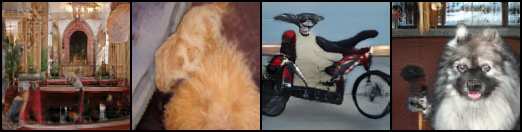

In [0]:
IPython.display.display(Image.fromarray(image_grid_np))

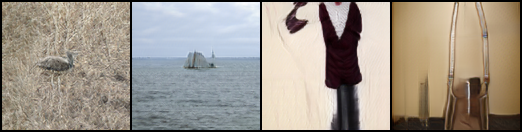

In [0]:
IPython.display.display(Image.fromarray(image_grid_np))

In [0]:
# Steer in BigGAN latent space towards the direction of  classifier.
# Classifier uses modified resnet18
import torch, torchvision
import torch.nn as nn
from torchvision.models import resnet18



In [0]:
# Load pre-trained resnet18
classifier1_model = resnet18(pretrained=True)

# By default resnet18 contains 1000 output features 
#Modify to 4 classes: Evil, Radiant, Dense, Minimal.
# ["guilty", "tragic", "rush", "hectic", "tired", "stupid", "evil", "energetic", "friendly", "loyal", "angry", "disappoint", "confident", "anxious", "austere", "authentic", "witty", "painful", "minimal", "modern", "progressive", "surreal", "aggressive", "intense", "inspirational", "artistic", "appealing", "luminous", "baroque", "beautiful", "brilliant", "candid", "atmospheric", "mystical", "organix", "candid", "ceramic", "avante-garde", "intuitive", "passionate", "peaceful", "complex", "classic"]

n_class = 4
num_in_features = classifier1_model.fc.in_features
classifier1_model.fc = nn.Linear(num_in_features, n_class)
classifier1_model = classifier1_model.cuda() # Ensure model runs on CUDA

In [0]:
# Load weights from GDrive: Classifier_weights/classifier_e-3.pth
ls /content/gdrive/My\ Drive/Classifier_weights/

classifier_e-3.pth  _out_image/


In [0]:
# Path to weights
classifier1_state_dict = "/content/gdrive/My Drive/Classifier_weights/classifier_e-3.pth"



In [0]:
# Load weights
classifier1_model.load_state_dict(torch.load(classifier1_state_dict))



<All keys matched successfully>

In [0]:
#classifier1_model.eval()

torch.Size([3, 128, 128])
(128, 128, 3)


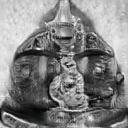

tensor([[-1.5473, -1.2002, -0.9428, -1.2426]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [0]:
# Classifier classifies images as Evil, Radiant, Dense or Minimal
# Test the classifier on a randomly generated sample from BigGAN latent space
with torch.no_grad():
    z_.sample_()
    y_.sample_()
    image_tensors = G(z_, G.shared(y_))
    image_sample_0 = torchvision.utils.make_grid(
        image_tensors[0],
        nrow=1,
        normalize=True,
    )

print(image_sample_0.shape)
image_sample_0_np = image_sample_0.cpu().numpy().transpose(1, 2, 0) * 255
image_sample_0_np = np.uint8(image_sample_0_np)
print(image_sample_0_np.shape)

IPython.display.display(Image.fromarray(image_sample_0_np))

# Transform to tensor
img = torchvision.transforms.ToTensor()((image_sample_0_np))
img = 0.5 + 0.5 * (img - img.mean()) / img.std()
img = img.unsqueeze(0) 

classifier1_model(img.cuda())



In [0]:
# Define a function to transform  an existing image towards a given classifier direction.
# E.g. make it more "evil" by increasing its evil score from the classifier.
# Finally, we  can start travelling in latent soup


In [0]:
# training parameters
dim_z = z_.shape[1]
learning_rate = 0.00001 # 0.0001 , 0.000001
num_samples = 1000 # 100 , 10,000
n_epoch = 1000 # 2500 , 100 , 1. 
save_freq = 100 # frequency to save weights

In [0]:
print(dim_z) # z_.shape[1] // [4,120]
print(transform.Nsliders)

120


NameError: ignored

In [0]:

class ColorTransform:
  def __init__(self):
    self.Nsliders = 3
    self.num_channels = 3
  
  def get_target_np(self, outputs_zs, alpha):
    ''' return target image and mask '''
    outputs_zs = outputs_zs.transpose(0, 2, 3, 1)
    mask_out = np.ones(outputs_zs.shape)
    if not np.any(alpha): # alpha is all zeros
      return outputs_zs, mask_out, np.count_nonzero(mask_out)
    target_fn = np.copy(outputs_zs)
    for b in range(alpha.shape[0]):
      for i in range(self.num_channels):
        target_fn[b,:,:,i] = target_fn[b,:,:,i]+alpha[b,i]
    target_fn = target_fn.transpose(0, 3, 1, 2)
    mask_out = mask_out.transpose(0, 3, 1, 2)
    return target_fn, mask_out, np.count_nonzero(mask_out)

  def get_train_alpha(self, batch_size):
    ''' get an alpha for training, return in format
      alpha_val_for_graph, alpha_val_for get_target_np'''
    alpha_val = np.random.random(size=(batch_size, self.num_channels))-0.5
    # graph and target use the same slider value
    alpha_val_for_graph = alpha_val
    alpha_val_for_target = alpha_val
    return alpha_val_for_graph, alpha_val_for_target
   

  def scale_test_alpha_for_graph(self, alpha, batch_size, channel=None,
                   contrast=True):
    ''' map a scalar alpha to the appropriate shape,
      and do the desired transformation '''
    if channel is None:
      slider = alpha * np.ones((batch_size, self.num_channels))
    else:
      assert(channel >= 0)
      assert(channel < self.num_channels)
      if contrast: # contrast is good for vis
        slider = -alpha * np.ones((batch_size, self.Nsliders))
      else: # good for channel-specific effects
        slider = np.zeros((batch_size, self.Nsliders))
      slider[:, channel] = alpha
    return slider
  
  def vis_alphas(self, num_panels=7, alpha_min=0, alpha_max=1):
    return np.linspace(alpha_min, alpha_max, num_panels)

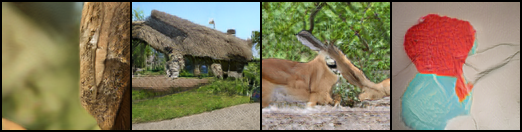

In [0]:
IPython.display.display(Image.fromarray(image_grid_np))

In [0]:
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)
print("Image Grid Shape: {}".format(np.shape(image_grid_np)))
print("Max pixel value: {}".format(np.max(image_grid_np)))
print("Min pixel value: {}".format(np.min(image_grid_np)))

Image Grid Shape: (132, 522, 3)
Max pixel value: 254
Min pixel value: 0
